In [1]:
import numpy as np

from bullet_utils.env import BulletEnvWithGround
from robot_properties_solo.solo12wrapper import Solo12Robot, Solo12Config

import pinocchio as pin
import time

from functools import partial

import mim_control_cpp
import matplotlib.pylab as plt

from mim_data_utils import DataLogger

import traceback

import array
import asyncio
import datetime
import json
import websockets
import threading

In [2]:
bullet_env = BulletEnvWithGround()

# Create a robot instance. This initializes the simulator as well.
robot = Solo12Robot()
bullet_env.add_robot(robot)

In [3]:
class SimHead:
    def __init__(self, robot, vicon_name=''):
        self._robot = robot
        
        self._vicon_name = vicon_name
        
        # Define the common sensor values.
        nv = robot.pin_robot.model.nv
        
        # Get number of joints nj
        if robot.useFixedBase:
            nj = nv
        else:
            nj = nv - 6
            
        self._sensor_joint_positions = np.zeros(nj)
        self._sensor_joint_velocities = np.zeros(nj)
        self._sensor_slider_positions = np.zeros(4)
        
        # If not fixed base, then assume we have an IMU and a vicon.
        if not robot.useFixedBase:
            # Simulated IMU.
            self._sensor_imu_gyroscope = np.zeros(3)
            
            # Utility for vicon class.
            self._sensor__vicon_base_position = np.zeros(7)
            self._sensor__vicon_base_velocity = np.zeros(6)
            
        # Controls.
        self._control_ctrl_joint_torques = np.zeros(nj)
            
    def read(self):
        q, dq = self._robot.get_state()
                
        self._sensor_joint_positions[:] = q[7:]
        self._sensor_joint_velocities[:] = dq[6:]
        
        self._sensor_imu_gyroscope[:] = dq[3:6].copy()
        
        self._sensor__vicon_base_position[:] = q[:7]
        self._sensor__vicon_base_velocity[:] = dq[:6]
        
        # TODO: Add noise and delay model.
        
    def write(self):
        self._robot.send_joint_command(self._control_ctrl_joint_torques)
        
    def get_sensor(self, sensor_name):
        return self.__dict__['_sensor_' + sensor_name]
    
    def set_control(self, control_name, value):
        self.__dict__['_control_' + control_name][:] = value
        
    def reset_state(self, q, dq):
        self._robot.reset_state(q, dq)

In [4]:
class ZeroTorquesController:
    def __init__(self, head):
        # Zero the commands.
        self.tau = np.zeros_like(head.get_sensor('joint_positions'))

    def warmup(self, thread):
        pass

    def run(self, thread):
        thread.head.set_control('ctrl_joint_torques', self.tau)

class SimVicon:
    def __init__(self, objects):
        self.objects = objects
        self.bias_xyz = np.zeros((len(objects), 3))
        self.vicon_frames = {}
        
    def update(self, thread_head):
        self.vicon_frames = {}
        
        for i, obj in enumerate(self.objects):
            robot, frame = obj.split('/')
            assert robot == frame, "Not supporting other frames right now."
            
            # Seek the head with the vicon object.
            for name, head in thread_head.heads.items():
                if head._vicon_name == robot:
                    self.vicon_frames[obj] = {
                        'idx': i,
                        'head': head
                    }
                    
        
    def get_state(self, vicon_object):
        head = self.vicon_frames[vicon_object]['head']
        pos = head._sensor__vicon_base_position.copy()
        pos[:3] -= self.bias_xyz[self.vicon_frames[vicon_object]['idx']]
        return (
            pos,
            head._sensor__vicon_base_velocity.copy()
        )
    
    def reset_bias(self, vicon_object):
        self.bias_xyz[:] = 0
    
    def bias_position(self, vicon_object):
        head = self.vicon_frames[vicon_object]['head']
        self.bias_xyz[self.vicon_frames[vicon_object]['idx'], :2] = head._sensor__vicon_base_position[:2].copy()


    
head = SimHead(robot, vicon_name='solo12')
thread_head = ThreadHead(0.001, ZeroTorquesController(head), head, [
    ('vicon', SimVicon(['solo12/solo12']))
], bullet_env)

Hello world from websocket thread. <ThreadHead(Thread-4, initial)>


In [5]:
class CentroidalController:
    def __init__(self, head, vicon_name, mu, kp, kd, kc, dc, kb, db):
        self.set_k(kp, kd)
        self.robot = Solo12Config.buildRobotWrapper()
        self.vicon_name = vicon_name

        self.x_com = [0.0, 0.0, 0.20]
        self.xd_com = [0.0, 0.0, 0.0]

        self.x_des = np.array([ 
             0.2, 0.142, 0.015,  0.2, -0.142,  0.015,
            -0.2, 0.142, 0.015, -0.2, -0.142,  0.015
        ])
        self.xd_des = np.array(4*[0., 0., 0.])

        self.x_ori = [0., 0., 0., 1.]
        self.x_angvel = [0., 0., 0.]
        self.cnt_array = 4*[1,]
        
        self.w_com = np.zeros(6)
        
        q_init = np.zeros(19)
        q_init[7] = 1
        self.centrl_pd_ctrl = mim_control_cpp.CentroidalPDController()
        self.centrl_pd_ctrl.initialize(2.5, np.diag(self.robot.mass(q_init)[3:6, 3:6]))

        self.force_qp = mim_control_cpp.CentroidalForceQPController()
        self.force_qp.initialize(4, mu, np.array([5e5, 5e5, 5e5, 1e6, 1e6, 1e6]))
                
        root_name = 'universe'
        endeff_names = ['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']
        self.imp_ctrls = [mim_control_cpp.ImpedanceController() for eff_name in endeff_names]
        for i, c in enumerate(self.imp_ctrls):
            c.initialize(self.robot.model, root_name, endeff_names[i])
        
        self.kc = np.array(kc)
        self.dc = np.array(dc)
        self.kb = np.array(kb)
        self.db = np.array(db)
                
        self.joint_positions = head.get_sensor('joint_positions')
        self.joint_velocities = head.get_sensor('joint_velocities')
        self.slider_positions = head.get_sensor('slider_positions')
        self.imu_gyroscope = head.get_sensor('imu_gyroscope')

    def set_k(self, kp, kd):
        self.kp = 4 * [kp, kp, kp, 0, 0, 0]
        self.kd = 4 * [kd, kd, kd, 0, 0, 0]

    def warmup(self, thread):
        thread.vicon.bias_position(self.vicon_name)
        self.zero_sliders = self.slider_positions.copy()

    def get_base(self, thread):
        base_pos, base_vel = thread.vicon.get_state(self.vicon_name)
        base_vel[3:] = self.imu_gyroscope
        return base_pos, base_vel
    
    def run(self, thread):
        base_pos, base_vel = self.get_base(thread)

        self.q = np.hstack([base_pos, self.joint_positions])
        self.dq = np.hstack([base_vel, self.joint_velocities])

        self.w_com[:] = 0
        
        self.centrl_pd_ctrl.run(
            self.kc, self.dc, self.kb, self.db,
            self.q[:3], self.x_com, self.dq[:3], self.xd_com,
            self.q[3:7], self.x_ori, self.dq[3:6], self.x_angvel
        )
        
        self.w_com[2] = 9.81 * Solo12Config.mass
        self.w_com += self.centrl_pd_ctrl.get_wrench()
        
        if hasattr(self, 'update_w_com'):
            self.update_w_com(thread)
        
#         # distrubuting forces to the active end effectors
        pin_robot = self.robot
        pin_robot.framesForwardKinematics(self.q)
        com = self.com = pin_robot.com(self.q)
        rel_eff = np.array([
            pin_robot.data.oMf[i].translation - com for i in Solo12Config.end_eff_ids
        ]).reshape(-1)
                
        ext_cnt_array = [1., 1., 1., 1.]
        self.force_qp.run(self.w_com, rel_eff, ext_cnt_array)
        self.F = self.force_qp.get_forces()
        
        if hasattr(self, 'update_F'):
            self.update_F(thread)
        
        # passing forces to the impedance controller
        self.tau = np.zeros(18)
        for i, c in enumerate(self.imp_ctrls):
            c.run(self.q, self.dq,
                 np.array(self.kp[6*i:6*(i+1)]),
                 np.array(self.kd[6*i:6*(i+1)]),
                 1.,
                 pin.SE3(np.eye(3), np.array(self.x_des[3*i:3*(i+1)])),
                 pin.Motion(self.xd_des[3*i:3*(i+1)], np.zeros(3)),
                 pin.Force(self.F[3*i:3*(i+1)], np.zeros(3))
             )

            self.tau += c.get_torques()
                
        head.set_control('ctrl_joint_torques', self.tau[6:])

In [6]:
ctrl = centroidal_controller = CentroidalController(head, 'solo12/solo12', 0.2, 50., 0.7,
    [100., 100., 100.], [15., 15., 15.], [25., 25., 25.], [22.5, 22.5, 22.5]
)

q0 = np.array(Solo12Config.initial_configuration)
q0[0] = 0.
q0[2] -= 0.01

dq0 = np.array(Solo12Config.initial_velocity)
thread_head.head.reset_state(q0, dq0)

thread_head.switch_controllers(centroidal_controller)

!!! ThreadHead: Start streaming data.
!!! ThreadHead: Start logging to file "2021-06-20_09-58-26.mds".
!!! ThreadHead: Stop streaming data.
!!! ThreadHead: Stop logging to file "2021-06-20_09-58-26.mds".


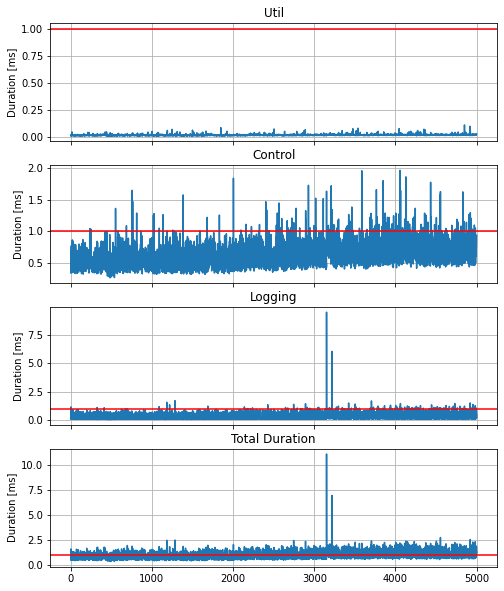

In [7]:
import gc

gc.disable()

thread_head.start_streaming()
thread_head.start_logging()

thread_head.sim_run(10000)

thread_head.stop_streaming()
thread_head.stop_logging()

thread_head.plot_timing()

gc.enable()